## Imports

With GPU this notebook is able to run in minutes per epoch.

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import os
from tqdm import tqdm
from shutil import copyfile, move

## Loading Data

In [9]:
dataset_df = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
dataset_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [16]:
dataset_df['label'] = dataset_df['label'].astype("string")
dataset_df["filename"] = [item.id+".tif" for idx, item in dataset_df.iterrows()]
dataset_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


## Exploratory Data Analysis (EDA)

Let us check if the data is imbalanced.

In [12]:
sum(dataset_df['label'] == 0)/len(dataset_df)

0.5949687535507329

Note that the evaluation metric on the test set being used is the area under the ROC curve (AUC). Though we need a continuous loss function for gradient descent, early stopping on the validation set can be dictated by AUC to  

Also the volatility for any metric being used on the validation set is quit high so early stopping to overfitting is important. For mini-experiments and for a robust validation set, only 20% is initilaly used for trianing which will be increased later when it is more clear which model will be used.

In [17]:
training_sample_percentage = 0.1
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

In [18]:
training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 22002 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [21]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model1 = Sequential()
model1.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model1.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model1.layers[0].trainable = False

model1.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

model1.summary()

2022-12-07 16:13:00.482561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:13:00.619335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:13:00.620106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:13:00.621335: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


As binary crossentropy loss and AUC are slightly different measures and the competition is for a good AUC score, early stopping is pegged to a good validation AUC instead of loss. 

In [22]:
train_step_size = train_generator.n // train_generator.batch_size
epochs = 10
#filepath = 'best_model.h5'
#check = ModelCheckpoint(filepath,
                        #monitor='val_auc',  # validation AUC
                        #save_best_only=True,
                        #mode='max')
es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model1.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-12-07 16:16:40.979597: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-07 16:16:45.441514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


171/171 [==============================] - 167s 920ms/step - loss: 0.4982 - auc: 0.8539 - val_loss: 0.5573 - val_auc: 0.8431
Epoch 2/10
171/171 [==============================] - 32s 189ms/step - loss: 0.3853 - auc: 0.9054 - val_loss: 0.3969 - val_auc: 0.9086
Epoch 3/10
171/171 [==============================] - 32s 188ms/step - loss: 0.3604 - auc: 0.9164 - val_loss: 0.2683 - val_auc: 0.9503
Epoch 4/10
171/171 [==============================] - 33s 194ms/step - loss: 0.3426 - auc: 0.9239 - val_loss: 0.3304 - val_auc: 0.9319
Epoch 5/10
171/171 [==============================] - 33s 192ms/step - loss: 0.3275 - auc: 0.9301 - val_loss: 0.3840 - val_auc: 0.9098


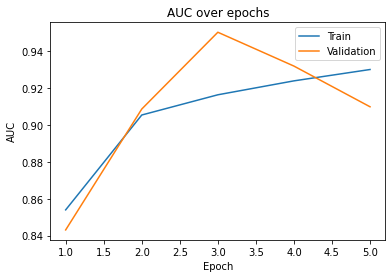

In [23]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

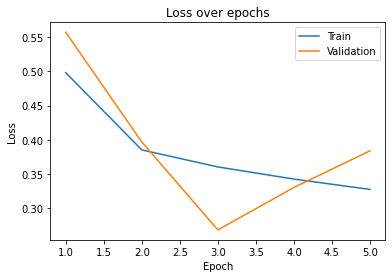

In [24]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [25]:
training_sample_percentage = 0.2
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df2 = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df2 = dataset_df[~dataset_df.index.isin(training_df.index)]

training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

#data_generator.fit(training_df2)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df2,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df2,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 44005 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [26]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model2 = Sequential()
model2.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model2.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model2.layers[0].trainable = False

model2.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

train_step_size = train_generator.n // train_generator.batch_size
epochs = 10
#filepath = 'best_model.h5'
#check = ModelCheckpoint(filepath,
                        #monitor='val_auc',  # validation AUC
                        #save_best_only=True,
                        #mode='max')
es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model2.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
343/343 [==============================] - 173s 496ms/step - loss: 0.4254 - auc: 0.8882 - val_loss: 0.2782 - val_auc: 0.9466
Epoch 2/10
343/343 [==============================] - 60s 176ms/step - loss: 0.3538 - auc: 0.9197 - val_loss: 0.2967 - val_auc: 0.9433
Epoch 3/10
343/343 [==============================] - 60s 176ms/step - loss: 0.3364 - auc: 0.9270 - val_loss: 0.2661 - val_auc: 0.9637
Epoch 4/10
343/343 [==============================] - 61s 178ms/step - loss: 0.3274 - auc: 0.9308 - val_loss: 0.3366 - val_auc: 0.9264
Epoch 5/10
343/343 [==============================] - 60s 174ms/step - loss: 0.3241 - auc: 0.9321 - val_loss: 0.2817 - val_auc: 0.9523


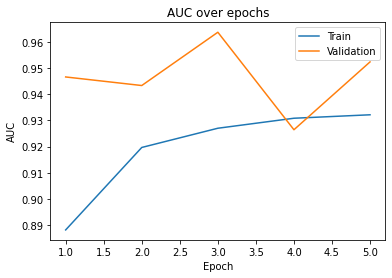

In [27]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

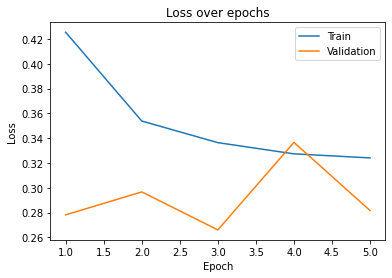

In [28]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [29]:
training_sample_percentage = 0.3
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df3 = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df3 = dataset_df[~dataset_df.index.isin(training_df.index)]

training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df3,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df3,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 66007 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [30]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model3 = Sequential()
model3.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model3.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model3.layers[0].trainable = False

model3.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

train_step_size = train_generator.n // train_generator.batch_size
epochs = 10
#filepath = 'best_model.h5'
#check = ModelCheckpoint(filepath,
                        #monitor='val_auc',  # validation AUC
                        #save_best_only=True,
                        #mode='max')
es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model3.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
515/515 [==============================] - 197s 377ms/step - loss: 0.4250 - auc: 0.8886 - val_loss: 0.4204 - val_auc: 0.8961
Epoch 2/10
515/515 [==============================] - 89s 172ms/step - loss: 0.3499 - auc: 0.9214 - val_loss: 0.3409 - val_auc: 0.9252
Epoch 3/10
515/515 [==============================] - 89s 173ms/step - loss: 0.3343 - auc: 0.9277 - val_loss: 0.4735 - val_auc: 0.8933
Epoch 4/10
515/515 [==============================] - 90s 175ms/step - loss: 0.3275 - auc: 0.9308 - val_loss: 0.3135 - val_auc: 0.9346
Epoch 5/10
515/515 [==============================] - 90s 174ms/step - loss: 0.3256 - auc: 0.9318 - val_loss: 0.3226 - val_auc: 0.9318
Epoch 6/10
515/515 [==============================] - 88s 171ms/step - loss: 0.3211 - auc: 0.9335 - val_loss: 0.3980 - val_auc: 0.9008


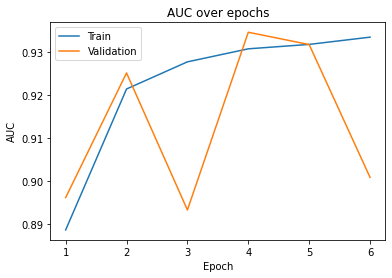

In [31]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

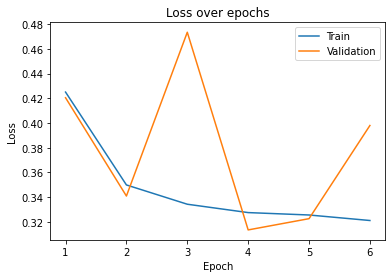

In [32]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [37]:
|Units|Mean Absolute Error (Validation)|
|:----|:--------:|
|10|6.161|
|20|5.119|
|50|5.332|
|100|4.635|
|200|4.706|
|500|4.531|

|Units|Mean Absolute Error (Validation)|
|:----|:--------:|
|10|6.161|
|20|5.119|
|50|5.332|
|100|4.635|
|200|4.706|
|500|4.531|

SyntaxError: invalid syntax (3226137550.py, line 1)

In [34]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model6 = Sequential()
model6.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model6.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model6.layers[0].trainable = True

model6.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

train_step_size = train_generator.n // train_generator.batch_size
epochs = 10
#filepath = 'best_model.h5'
#check = ModelCheckpoint(filepath,
                        #monitor='val_auc',  # validation AUC
                        #save_best_only=True,
                        #mode='max')
es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model6.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
515/515 [==============================] - 109s 201ms/step - loss: 0.4818 - auc: 0.9016 - val_loss: 1.4002 - val_auc: 0.8689
Epoch 2/10
515/515 [==============================] - 104s 202ms/step - loss: 0.2652 - auc: 0.9558 - val_loss: 0.7622 - val_auc: 0.8607
Epoch 3/10
515/515 [==============================] - 101s 195ms/step - loss: 0.2580 - auc: 0.9634 - val_loss: 1.2562 - val_auc: 0.7297


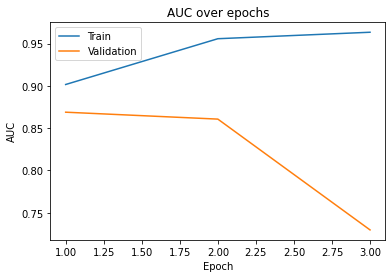

In [35]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

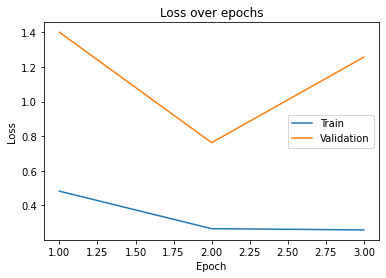

In [36]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
import os
from tqdm import tqdm
from shutil import copyfile, move

src="../input/histopathologic-cancer-detection/test"

test_folder="../test_folder"
dst = test_folder+"/test"
os.mkdir(test_folder)
os.mkdir(dst)

file_list =  os.listdir(src)
with tqdm(total=len(file_list)) as pbar:
    for filename in file_list:
        pbar.update(1)
        copyfile(src+"/"+filename,dst+"/"+filename)

In [ ]:
test_generator = data_generator.flow_from_directory(
    directory=test_folder,
    target_size=target_size,
    shuffle=False,
    class_mode='binary'
)

In [ ]:
pred = my_new_model.predict(test_generator,verbose=1)

In [ ]:
pred = my_new_model.predict(test_generator,verbose=1)

In [ ]:
pred[:10]

In [24]:
sub = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
sub['label'] = pred
sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.930296
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.969706
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.201962
3,2c35657e312966e9294eac6841726ff3a748febf,0.863110
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.023512


In [25]:
sub.to_csv('submission.csv', index=False)

In [27]:
pred = my_new_model.predict(test_generator,verbose=1)

csv_file = open("sample_submission.csv","w")
csv_file.write("id,label\n")
for filename, prediction in zip(test_generator.filenames,pred):
    name = filename.split("/")[1].replace(".tif","")
    csv_file.write(str(name)+","+str(prediction[0])+"\n")
csv_file.close()

   1/1796 [..............................] - ETA: 2:04

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1796/1796 [==============================] - 70s 39ms/step


In [28]:
sub2 = pd.read_csv('./submission.csv')
sub2.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.930296
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.969706
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.201962
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.863110
4,000270442cc15af719583a8172c87cd2bd9c7746,0.023512


In [ ]:
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
my_new_model.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
my_new_model.layers[0].trainable = False

my_new_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=[AUC(name="auc")])

my_new_model.summary()

In [ ]:
fit_stats = my_new_model.fit(train_generator,
                            steps_per_epoch=train_step_size,
                            validation_data=validation_generator,
                            validation_steps=1,
                            epochs = epochs,
                            callbacks = [es], 
                            verbose=1)

In [ ]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
pred=my_new_model.predict(test_generator,verbose=1)

In [ ]:
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
my_new_model.add(Dense(10))
my_new_model.add(Dropout(0.5))
my_new_model.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
my_new_model.layers[0].trainable = False

my_new_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=[AUC(name="auc")])

my_new_model.summary()

In [ ]:
fit_stats = my_new_model.fit(train_generator,
                            steps_per_epoch=train_step_size,
                            validation_data=validation_generator,
                            validation_steps=1,
                            epochs = epochs,
                            callbacks = [es], 
                            verbose=1)

In [ ]:
training_sample_percentage = 0.5
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

In [ ]:
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
my_new_model.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
my_new_model.layers[0].trainable = False

my_new_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=[AUC(name="auc")])

fit_stats = my_new_model.fit(train_generator,
                            steps_per_epoch=train_step_size,
                            validation_data=validation_generator,
                            validation_steps=1,
                            epochs = epochs,
                            callbacks = [es], 
                            verbose=1)

In [ ]:
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
my_new_model.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
my_new_model.layers[0].trainable = True

my_new_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=[AUC(name="auc")])

fit_stats = my_new_model.fit(train_generator,
                            steps_per_epoch=train_step_size,
                            validation_data=validation_generator,
                            validation_steps=1,
                            epochs = epochs,
                            callbacks = [es], 
                            verbose=1)

In [ ]:
training_sample_percentage = 0.8
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

In [ ]:
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
my_new_model.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
my_new_model.layers[0].trainable = True

my_new_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=[AUC(name="auc")])

fit_stats = my_new_model.fit(train_generator,
                            steps_per_epoch=train_step_size,
                            validation_data=validation_generator,
                            validation_steps=1,
                            epochs = epochs,
                            callbacks = [es], 
                            verbose=1)

In [ ]:
pred = my_new_model.predict(test_generator,verbose=1)

csv_file = open("sample_submission.csv","w")
csv_file.write("id,label\n")
for filename, prediction in zip(test_generator.filenames,pred):
    name = filename.split("/")[1].replace(".tif","")
    csv_file.write(str(name)+","+str(prediction[0])+"\n")
csv_file.close()